# Pratishtha Singh-8927578830

## 2. Active Learning Using Support Vector Machines

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.


### (a) Train Test Split

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn import svm

df=pd.read_csv("data_banknote_authentication.csv", header=None, names=['Variance','Skewness','Curtosis','Entropy','Class'])
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
data_x=df.iloc[:,:4]
data_y=df.iloc[:,4:5]
x_train, x_test, y_train, y_test=train_test_split(data_x, data_y, test_size=472)
normalized_x_train=preprocessing.normalize(x_train)
normalized_x_test=preprocessing.normalize(x_test)

### (b) (i) Passive Learning 

In [8]:
%%time
import random
from sklearn.metrics import accuracy_score
avg_test_error=[]
df_err=pd.DataFrame()
for i in range(0,50):
    test_errors=[]
    df_pool_train = pd.DataFrame()
    # Test Train split
    data_x = df.iloc[:,:4]
    data_y = df.iloc[:,4:5]
    
    # Normalize the features in the dataframe 
    x_array = data_x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_array)
    ndf_x = pd.DataFrame(x_scaled)
    x_train, x_test, y_train, y_test = train_test_split(ndf_x, data_y, test_size=472)
    df_train = pd.DataFrame(x_train)
    df_train = pd.concat([df_train,y_train],axis=1)
    df_train.columns = df.columns
    df_train.reset_index(inplace=True,drop=True)

    while(len(df_train)!=0):
        # Randomly selecting 10 datapoints from the train dataset
        random = df_train.sample(n=10)
        # Adding the points in the pool
        df_pool_train = df_pool_train.append(random)
        # Droping the indices from the training set
        df_train = df_train.drop(index=random.index)
        
        x = df_pool_train.iloc[:,:4]
        y = df_pool_train.iloc[:,4:5]
        # Finding the best tuning paramater using GridSearchCV
        C = np.logspace(-4, 4, 9)
        svm_linear_model = svm.LinearSVC(penalty='l1',dual=False)
        tuned_paramater = dict(C=C)
        gscv = GridSearchCV(svm_linear_model, tuned_paramater, cv=5, n_jobs=-1)
        
        gscv.fit(x,y,groups=None)
        y_pred = gscv.best_estimator_.predict(x_test)
        acc_sc_test=accuracy_score(y_test,y_pred)
        test_err=1-acc_sc_test
        test_errors.append(test_err)
    errors=pd.Series(test_errors)
    df_err.insert(loc=i,column=i,value=errors)
    avg_test_error=df_err.mean(axis=1)


Wall time: 21min 54s


MinMaxScalar reference from https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

In [9]:
s=range(10,910,10)
df_p=pd.DataFrame({'# of Samples in SVM':s,'Average Test Error':avg_test_error})
df_p

,# of Samples in SVM,Average Test Error
0,10,0.183771
1,20,0.072881
2,30,0.050254
3,40,0.047458
4,50,0.029153
5,60,0.025508
6,70,0.024237
7,80,0.022839
8,90,0.021992
9,100,0.021229


### (b) (i) Active Learning

In [174]:
%%time
avg_test_error_active=[]
df_err_a=pd.DataFrame()
for i in range(0,50):
    test_errors=[]
    df_pool_train = pd.DataFrame()
    # Test Train split
    data_x = df.iloc[:,:4]
    data_y = df.iloc[:,4:5]
    # Normalize the features in the dataframe 
    x_array = data_x.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_array)
    ndf_x = pd.DataFrame(x_scaled)
    x_train, x_test, y_train, y_test = train_test_split(ndf_x, data_y, test_size=472)
    df_train = pd.DataFrame(x_train)
    df_train = pd.concat([df_train,y_train],axis=1)
    df_train.columns = df.columns
    
    # Randomly selecting 10 datapoints from the train dataset
    random = df_train.sample(n=10)
    # Adding the points in the pool
    df_pool_train = df_pool_train.append(random)
    # Droping the indices from the training set
    df_train = df_train.drop(index=random.index)
    df_train.reset_index(inplace=True,drop=True)
    
    x = df_pool_train.iloc[:,:4]
    y = df_pool_train.iloc[:,4:5]
    # Finding the best tuning paramater using GridSearchCV
    C = np.logspace(-4, 4, 9)
    svm_linear_model = svm.LinearSVC(penalty='l1',dual=False)
    tuned_paramater = dict(C=C)
    gscv = GridSearchCV(svm_linear_model, tuned_paramater, cv=5, n_jobs=-1)
    
    gscv.fit(x,y)
    ypred = gscv.best_estimator_.predict(x_test)
    ac_sc_test=accuracy_score(y_test,ypred)
    test_er=1-ac_sc_test
    
    while(len(df_train)!=0):
        x = df_pool_train.iloc[:,:4]
        y = df_pool_train.iloc[:,4:5]
        train_x = df_train.iloc[:,:4]
        train_y = df_train.iloc[:,4:5]
        # Finding the best tuning paramater using GridSearchCV
        svm_linear_model = svm.LinearSVC(penalty='l1',dual=False)
        tuned_paramater = dict(C=C)
        gscv = GridSearchCV(svm_linear_model, tuned_paramater, cv=5, n_jobs=-1)
        gscv.fit(x,y)
        # Distance of points from the hyperplane
        dist = gscv.decision_function(train_x)
        absolute_distance_hyperplane = np.abs(dist)
        # 10 points closest to the hyperplane 
        sorted_10_distance_index=absolute_distance_hyperplane.argsort()[:10]
        # Append the closest 10 datapoints to the hyperplane in the pool
        df_pool_train=df_pool_train.append(df_train.iloc[sorted_10_distance_index,:])
        # Drop the indices from the train dataframe. 
        df_train = df_train.drop(df_train.iloc[sorted_10_distance_index].index)
        
        y_pred = gscv.best_estimator_.predict(x_test)
        acc_sc_test=accuracy_score(y_test,y_pred)
        test_err=1-acc_sc_test
        test_errors.append(test_err)
    test_errors.insert(0,test_er)
    errors=pd.Series(test_errors)
    df_err_a.insert(loc=i,column=i,value=errors)
    avg_test_error_active=df_err_a.mean(axis=1)
    

Wall time: 20min 45s


closest datapoint index refrence from https://stackoverflow.com/questions/41443118/select-5-data-points-closest-to-svm-hyperlane

In [175]:
s=range(10,910,10)
df_a=pd.DataFrame({'# of Samples in SVM':s,'Average Test Error':avg_test_error_active})
df_a

,# of Samples in SVM,Average Test Error
0,10,0.135636
1,20,0.134110
2,30,0.076271
3,40,0.033347
4,50,0.029619
5,60,0.017585
6,70,0.013305
7,80,0.011356
8,90,0.011864
9,100,0.011271


### (c) Learning Curve-Monte-Carlo simulation.

Text(0, 0.5, 'Average Test Errors')

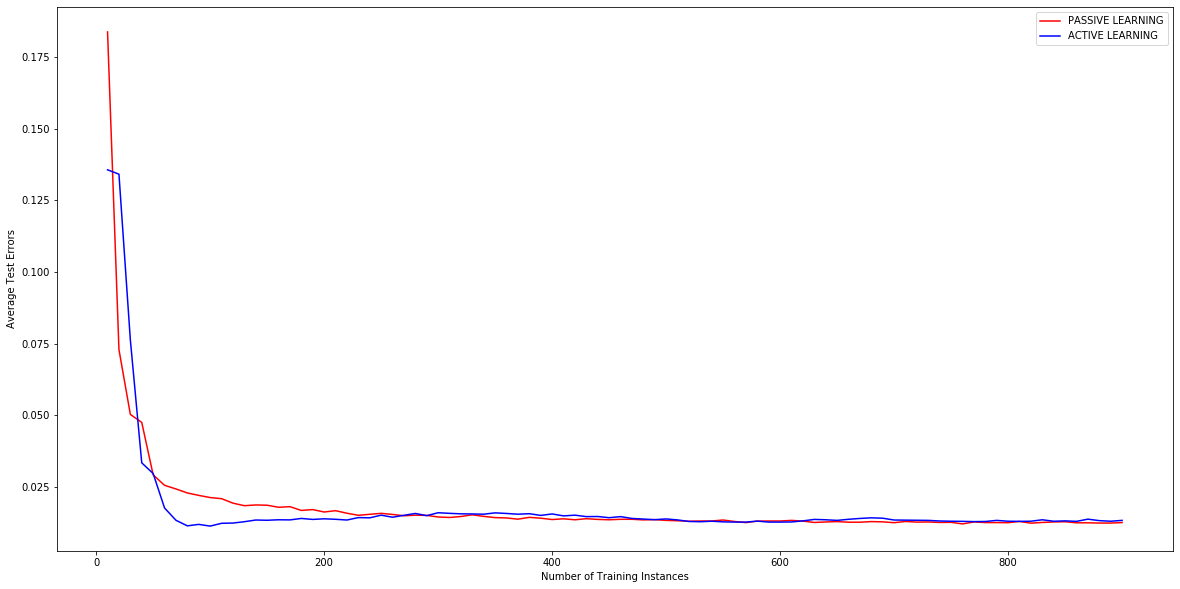

In [179]:
plt.figure(figsize=(20,10))
passive,=plt.plot(s,avg_test_error, color='red', label="PASSIVE LEARNING")
active,=plt.plot(s,avg_test_error_active, color='BLUE', label="ACTIVE LEARNING")
plt.legend()
plt.xlabel("Number of Training Instances")
plt.ylabel("Average Test Errors")

We can see that the minumum test error is given by Active Learning at approximately 0.0113. Apart from this, the test errors are almost the same but we can say that Active Learning performs slightly better than Passive Learning, especially in the beginning. After a point, approximately when the training instances become 240, both Active and Passive Learning give almost equal performance. 